In [1]:
library(forecast)
library(ggplot2)
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [23]:
library(doParallel)
library(doMC)
options(cores = 8)
registerDoMC()

In [3]:
library(data.table)
library(hts)  


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last



In [4]:
df_eu  <-  read.csv(file="hts_eu_a10.csv", header=TRUE, sep=",", row.names =1 )

In [5]:
gdp_agg <- rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = 4, start = 2000) 

In [6]:
gdp_agg  <-  gdp_agg/1000
df_eu  <-  df_eu/1000

### AR(3)LI with neighbors (different metrics)


#### xreg ts

In [7]:
library(dtw)
library(TSclust)

Loading required package: proxy

Attaching package: ‘proxy’

The following objects are masked from ‘package:stats’:

    as.dist, dist

The following object is masked from ‘package:base’:

    as.matrix

Loaded dtw v1.20-1. See ?dtw for help, citation("dtw") for use in publication.

Loading required package: wmtsa
Loading required package: pdc
Loading required package: cluster


- "ACF" Autocorrelation-based method. See diss.ACF.

- "AR.LPC.CEPS" Linear Predictive Coding ARIMA method. This method has two value-per-series arguments, the ARIMA order, and the seasonality.See diss.AR.LPC.CEPS.

- "AR.MAH" Model-based ARMA method. See diss.AR.MAH.

- "AR.PIC" Model-based ARMA method. This method has a value-per-series argument, the ARIMA order. See diss.AR.PIC.

- "CDM" Compression-based dissimilarity method. See diss.CDM.

- "CID" Complexity-Invariant distance. See diss.CID.

- "COR" Correlation-based method. See diss.COR.

- "CORT" Temporal Correlation and Raw values method. See diss.CORT.

- "DTWARP" Dynamic Time Warping method. See diss.DTWARP.

- "DWT" Discrete wavelet transform method. See diss.DWT.

- "EUCL" Euclidean distance. See diss.EUCL. For many more convetional distances, see link[stats]{dist}, though you may need to transpose the dataset.

- "FRECHET" Frechet distance. See diss.FRECHET.

- "INT.PER" Integrate Periodogram-based method. See diss.INT.PER.

- "NCD" Normalized Compression Distance. See diss.NCD.

- "PACF" Partial Autocorrelation-based method. See diss.PACF.

- "PDC" Permutation distribution divergence. Uses the pdc package. See pdcDist for additional arguments and details. Note that series given by numeric matrices are interpreted row-wise and not column-wise, opposite as in pdcDist.

- "PER" Periodogram-based method. See diss.PER.

- "PRED" Prediction Density-based method. This method has two value-per-series agument, the logarithm and difference transform. See diss.PRED.

- "MINDIST.SAX" Distance that lower bounds the Euclidean, based on the Symbolic Aggregate approXimation measure. See diss.MINDIST.SAX.

- "SPEC.LLR" Spectral Density by Local-Linear Estimation method. See diss.SPEC.LLR.

- "SPEC.GLK" Log-Spectra Generalized Likelihood Ratio test method. See diss.SPEC.GLK.

- "SPEC.ISD" Intregated Squared Differences between Log-Spectras method. See diss.SPEC.ISD.

#### DTWARP 

In [36]:
df_eu_diff  <-  apply(df_eu , 2 , diff )

In [37]:
df_eu_diff_4  <-  apply(df_eu_diff , 2 , function(x) diff(x, 4) )

In [38]:
df_eu  <- as.data.table(df_eu)
df_eu_diff_4  <- as.data.table(df_eu_diff_4)

In [39]:
dim(df_eu)
dim(df_eu_diff_4)

[1]  75 280

[1]  70 280

In [40]:
train  <- df_eu_diff_4[1:(68-5), ]

In [41]:
corr_mat <- diss(train, "DTWARP")

In [42]:
diss_mat_dtw  <- matrix(0, nrow = dim(train)[2], ncol = dim(train)[2])
i <- j  <- a  <- 1
while (i < dim(train)[2]){
  for (j in (i+1):dim(train)[2]){ 
    # cat("(", j, i, ")")
    diss_mat_dtw[j,i] <-  corr_mat[a]
    a <- a+1
    }
  i <-i+1
  }
diss_mat_dtw  <- diss_mat_dtw + t(diss_mat_dtw)
diag(diss_mat_dtw) <- NA

In [43]:
closests_dtw <- c()
for (i in 1:dim(df_eu)[2]){
    closests_dtw  <-  c(closests_dtw, which.min(diss_mat_dtw[i,]) )
}

In [44]:
names_dtw <- c()
for (i in closests_dtw){
    names_dtw  <-  c(names_dtw, colnames(train)[i])
}

In [45]:
iii  <- 130


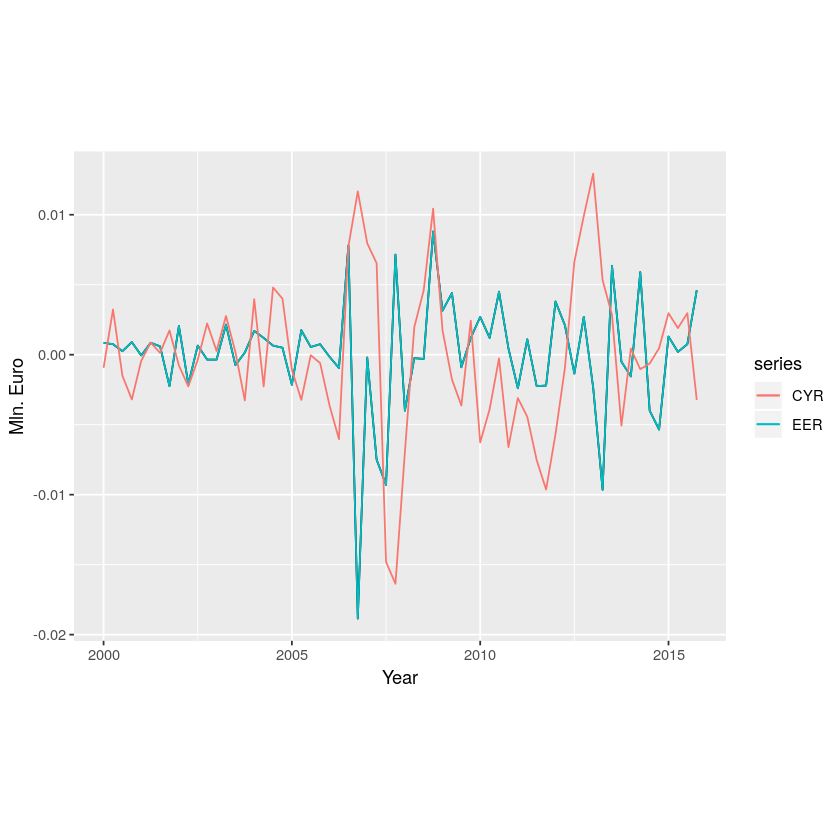

In [46]:
autoplot(ts(train[[names_dtw[iii]]], frequency = 4, start = 2000)) +
    autolayer(ts(train[[names_dtw[iii]]], frequency = 4, start = 2000), series=names_dtw[iii]) +
    autolayer(ts(train[[iii]], frequency = 4, start = 2000), series=colnames(train)[iii]) +
    xlab("Year") + ylab("Mln. Euro") +
    theme(aspect.ratio = 0.75)

#### 1 LAG

In [47]:
y  <-  hts(df_eu, characters = c(2,1))
gts_train  <- window(y, start=1, end=68)
gts_test  <- window(y, start=69, end=75)

In [48]:
names_dtw_1  <-  c(rep(NA, 29), names_dtw)
allts <- aggts(gts_train)
allf <- matrix(, nrow=7, ncol=ncol(allts))

In [49]:
start_time <- Sys.time()
for(i in 1:29){
    model  <- Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, method = "ML")
    allf[,i] <- forecast(model, h=7)$mean
}
ms <-  foreach(i=30:ncol(allts)) %dopar% {
    reg1  <-  lag(allts[,names_dtw_1[i]][1:length(allts[,names_dtw_1[i]])])
    tryCatch(        
        Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = reg1, method = "ML"), 
            error = function(e) Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = reg1, method = "CSS"))
    
#     forecast(ms[[i]], h=7)$mean
}
end_time <- Sys.time()
end_time - start_time

Time difference of 13.46698 secs

In [50]:
gts_xreg  <- window(y, start=68, end=74)

In [51]:
gts_xreg[[1]]

ATA,ATB,ATF,ATG,ATJ,ATK,ATL,ATM,ATO,ATR,⋯,UKA,UKB,UKF,UKG,UKJ,UKK,UKL,UKM,UKO,UKR
0.89065,18.27845,5.63635,18.56585,2.99815,3.18970,7.9045,8.30670,14.12205,2.23740,⋯,3.32365,72.45420,30.70315,91.19245,33.57805,38.16105,70.08445,63.60060,91.62565,20.92385
1.03250,18.01520,4.39055,18.90695,2.88050,3.25800,7.9679,7.46585,14.27320,2.24490,⋯,3.59320,74.97645,32.24720,92.44670,33.02210,37.84545,71.59135,64.38920,93.52510,22.22850
1.20875,18.06245,5.21615,18.47410,2.84580,3.31065,8.0615,7.91560,14.33190,2.28215,⋯,3.61505,72.49050,32.12795,93.37780,33.48840,38.39070,71.64390,65.20465,92.61890,22.95500
1.12585,18.05240,5.51870,18.96435,2.86735,3.32830,8.1856,8.18955,14.35740,2.28630,⋯,3.29030,69.75630,31.17990,90.96840,32.46695,35.16020,68.96380,63.84680,89.37170,22.18445
1.09515,18.55240,5.88915,19.30215,3.13615,3.41165,8.3175,8.69640,14.54885,2.28910,⋯,3.37820,74.50155,31.97810,92.24005,35.13315,36.63770,70.41395,66.32350,91.69625,22.15745
1.14710,18.83185,4.64855,19.75920,2.99555,3.48065,8.4335,8.10390,14.86715,2.30595,⋯,3.46795,76.03610,32.18300,92.37635,34.53595,37.06770,71.37610,66.69515,93.15065,21.99530
1.26070,19.01210,5.51185,19.30920,2.94800,3.28410,8.5505,8.36850,14.86670,2.33680,⋯,3.45315,74.99030,32.31600,95.32680,34.63635,38.04385,71.17480,67.98700,92.59380,22.36290


In [52]:
for(i in 30:ncol(allts)){
    allf[,i] <- forecast(ms[[i-29]], h=7, xreg=gts_xreg[[1]][,names_dtw_1[i]])$mean
    }

Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains d

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in th

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in th

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in th

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in th

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in th

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in th

In [53]:
allf <- ts(allf)
colnames(allf)  <-  colnames(allts)  
g <- get_nodes(gts_train)
y.f <- combinef(allf, nodes = g)
forecasts_7  <-  y.f[[1]]
colnames(forecasts_7)  <-  colnames(y[[1]])
data_f5  <-  rbind(gts_train[[1]], forecasts_7)
y_f5  <-  hts(data_f5, characters = c(2,1))

In [54]:
gts_forecasts_7  <- window(y_f5, start=69, end=75)

In [55]:
accuracy.gts(gts_forecasts_7, gts_test)

,Total,AT,BE,BG,CY,CZ,DE,DK,EE,EL,⋯,UKA,UKB,UKF,UKG,UKJ,UKK,UKL,UKM,UKO,UKR
ME,55.452122,0.1592184,-0.3899763,-0.7387659,-1.114259,1.459264,20.77050,-0.5963999,-0.9606873,0.2070718,⋯,1.036903,5.701680,3.235307,4.509644,1.760525,-1.584016,6.318369,4.558520,-1.980247,2.537810
RMSE,56.413296,0.6178734,0.5455135,0.8503348,1.202747,1.750854,22.57129,1.0574991,1.0457180,0.5805056,⋯,1.075660,5.996266,3.258633,4.589179,1.996958,2.178933,6.439407,4.688704,4.420348,2.613599
MAE,55.452122,0.4960431,0.4894781,0.7387659,1.114259,1.569865,20.77050,0.8905905,0.9606873,0.4234277,⋯,1.036903,5.701680,3.235307,4.509644,1.760525,1.803412,6.318369,4.558520,3.703187,2.537810
MAPE,1.592402,0.5854210,0.4942691,6.5253570,25.583233,3.461531,2.75155,1.3996123,18.0613584,1.0456769,⋯,30.349318,7.668023,10.098321,4.822494,5.104646,4.962060,8.921811,6.874455,4.013333,11.376345
MPE,1.592402,0.1800530,-0.3905533,-6.5253570,-25.583233,3.180009,2.75155,-0.9338171,-18.0613584,0.4941022,⋯,30.349318,7.668023,10.098321,4.822494,5.104646,-4.390577,8.921811,6.874455,-2.166458,11.376345


#### 4 LAG

In [56]:
names_dtw_1  <-  c(rep(NA, 29), names_dtw)
allts <- aggts(gts_train)
allf <- matrix(, nrow=7, ncol=ncol(allts))

In [57]:
start_time <- Sys.time()
for(i in 1:29){
    model  <- Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, method = "ML")
    allf[,i] <- forecast(model, h=7)$mean
}
ms <-  foreach(i=30:ncol(allts)) %dopar% {
    reg1  <-  lag(allts[,names_dtw_1[i]][1:length(allts[,names_dtw_1[i]])],4)
    tryCatch(        
        Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = reg1, method = "ML"), 
            error = function(e) Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = reg1, method = "CSS"))
#     forecast(ms[[i]], h=7)$mean
}
end_time <- Sys.time()
end_time - start_time

Time difference of 16.87701 secs

In [58]:
gts_xreg  <- window(y, start=(69-4), end=(75-4))

In [59]:
for(i in 30:ncol(allts)){
    allf[,i] <- forecast(ms[[i-29]], h=7, xreg=gts_xreg[[1]][,names_dtw_1[i]])$mean
    }

Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains d

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in th

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in th

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in th

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in th

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in th

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in th

In [60]:
allf <- ts(allf)
colnames(allf)  <-  colnames(allts)  
g <- get_nodes(gts_train)
y.f <- combinef(allf, nodes = g)
forecasts_7  <-  y.f[[1]]
colnames(forecasts_7)  <-  colnames(y[[1]])
data_f5  <-  rbind(gts_train[[1]], forecasts_7)
y_f5  <-  hts(data_f5, characters = c(2,1))

In [61]:
gts_forecasts_7  <- window(y_f5, start=69, end=75)

In [62]:
accuracy.gts(gts_forecasts_7, gts_test)

,Total,AT,BE,BG,CY,CZ,DE,DK,EE,EL,⋯,UKA,UKB,UKF,UKG,UKJ,UKK,UKL,UKM,UKO,UKR
ME,55.50263,0.1226815,-0.4428594,-0.7869648,-1.160944,1.444328,20.956078,-0.6338909,-1.006720,0.1543985,⋯,0.1677260,4.712493,3.930230,5.310681,1.114920,-3.301635,5.331325,4.590595,2.875828,2.080017
RMSE,56.46549,0.6037936,0.5869318,0.8957090,1.249528,1.729284,22.742951,1.0934798,1.091032,0.5629566,⋯,0.3720835,5.119455,3.971379,5.618238,1.324861,3.961992,5.452578,4.757246,3.693626,2.255131
MAE,55.50263,0.4958433,0.5320367,0.7869648,1.160944,1.545661,20.956078,0.9305798,1.006720,0.4368103,⋯,0.3180207,4.712493,3.930230,5.310681,1.114920,3.301635,5.331325,4.590595,3.444472,2.080017
MAPE,1.59385,0.5858771,0.5371368,6.9444308,26.655662,3.406671,2.776358,1.4624549,18.929856,1.0830851,⋯,9.2886649,6.322657,12.270157,5.664960,3.222625,9.059123,7.525655,6.951024,3.728048,9.306082
MPE,1.59385,0.1367881,-0.4441827,-6.9444308,-26.655662,3.148742,2.776358,-0.9927031,-18.929856,0.3631361,⋯,4.6103518,6.322657,12.270157,5.664960,3.222625,-9.059123,7.525655,6.951024,3.111230,9.306082


#### 1, 4 LAGS

In [63]:
allf <- matrix(, nrow=7, ncol=ncol(allts))

In [64]:
start_time <- Sys.time()
for(i in 1:29){
    model  <- Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, method = "ML")
    allf[,i] <- forecast(model, h=7)$mean
}
ms <-  foreach(i=30:ncol(allts)) %dopar% {
    reg1  <-  lag(allts[,names_dtw_1[i]][1:length(allts[,names_dtw_1[i]])])
    reg4  <-  lag(allts[,names_dtw_1[i]][1:length(allts[,names_dtw_1[i]])],4)
     
    
    tryCatch(        
        Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = cbind(reg1,reg4), method = "ML"), 
            error = function(e) Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = cbind(reg1,reg4), method = "CSS"))
#
    
    #     forecast(ms[[i]], h=7)$mean
}
end_time <- Sys.time()
end_time - start_time

Time difference of 15.57625 secs

In [65]:
gts_xreg1  <- window(y, start=(69-1), end=(75-1))
gts_xreg4  <- window(y, start=(69-4), end=(75-4))

In [66]:
for(i in 30:ncol(allts)){
    reg1f  <-  ts(gts_xreg1[[1]][,names_dtw_1[i]], start=2017)
    reg4f  <-  ts(gts_xreg4[[1]][,names_dtw_1[i]], start=2017)
    allf[,i] <- forecast(ms[[i-29]], h=7, xreg=cbind(reg1f,reg4f))$mean
    }

Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(

In [67]:
allf <- ts(allf)
colnames(allf)  <-  colnames(allts)  
g <- get_nodes(gts_train)
y.f <- combinef(allf, nodes = g)
forecasts_7  <-  y.f[[1]]
colnames(forecasts_7)  <-  colnames(y[[1]])
data_f5  <-  rbind(gts_train[[1]], forecasts_7)
y_f5  <-  hts(data_f5, characters = c(2,1))

In [68]:
gts_forecasts_7  <- window(y_f5, start=69, end=75)

In [69]:
accuracy.gts(gts_forecasts_7, gts_test)

,Total,AT,BE,BG,CY,CZ,DE,DK,EE,EL,⋯,UKA,UKB,UKF,UKG,UKJ,UKK,UKL,UKM,UKO,UKR
ME,55.480025,0.1367887,-0.4314460,-0.7662182,-1.140116,1.461463,20.762486,-0.5985986,-0.9860676,0.2088020,⋯,0.5438986,5.285674,4.044151,4.661334,1.439298,-2.425690,5.650834,4.590257,0.2172928,2.529574
RMSE,56.441261,0.6066465,0.5760165,0.8754133,1.227556,1.750158,22.539508,1.0606955,1.0696977,0.5835706,⋯,0.6036673,5.702987,4.095668,4.948349,1.659092,3.129005,5.768247,4.752993,3.4402826,2.666413
MAE,55.480025,0.4938722,0.5198512,0.7662182,1.140116,1.564927,20.762486,0.8954374,0.9860676,0.4260066,⋯,0.5438986,5.285674,4.044151,4.661334,1.439298,2.645773,5.650834,4.590257,2.5152208,2.529574
MAPE,1.593204,0.5832068,0.5248052,6.7660497,26.180066,3.449419,2.750656,1.4073195,18.5434580,1.0522360,⋯,15.8039826,7.101125,12.628022,4.970845,4.171337,7.255110,7.979003,6.948751,2.7179511,11.331652
MPE,1.593204,0.1536315,-0.4326561,-6.7660497,-26.180066,3.186064,2.750656,-0.9373304,-18.5434580,0.4987541,⋯,15.8039826,7.101125,12.628022,4.970845,4.171337,-6.681838,7.979003,6.948751,0.2146566,11.331652


#### 1:4 LAGS

In [70]:
allf <- matrix(, nrow=7, ncol=ncol(allts))

In [71]:
start_time <- Sys.time()
for(i in 1:29){
    model  <- Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, method = "ML")
    allf[,i] <- forecast(model, h=7)$mean
}
ms <-  foreach(i=30:ncol(allts)) %dopar% {
    reg1  <-  lag(allts[,names_dtw_1[i]][1:length(allts[,names_dtw_1[i]])])
    reg2  <-  lag(allts[,names_dtw_1[i]][1:length(allts[,names_dtw_1[i]])],2)
    reg3  <-  lag(allts[,names_dtw_1[i]][1:length(allts[,names_dtw_1[i]])],3)
    reg4  <-  lag(allts[,names_dtw_1[i]][1:length(allts[,names_dtw_1[i]])],4)
    
    tryCatch(        
        Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = cbind(reg1,reg2,reg3,reg4), method = "ML"), 
            error = function(e) Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = cbind(reg1,reg2,reg3,reg4), method = "CSS"))
#
    
    #     forecast(ms[[i]], h=7)$mean
}
end_time <- Sys.time()
end_time - start_time

Time difference of 22.19233 secs

In [72]:
gts_xreg1  <- window(y, start=(69-1), end=(75-1))
gts_xreg2  <- window(y, start=(69-2), end=(75-2))
gts_xreg3  <- window(y, start=(69-3), end=(75-3))
gts_xreg4  <- window(y, start=(69-4), end=(75-4))

In [73]:
for(i in 30:ncol(allts)){
    reg1f  <-  ts(gts_xreg1[[1]][,names_dtw_1[i]], start=2017)
    reg2f  <-  ts(gts_xreg2[[1]][,names_dtw_1[i]], start=2017)
    reg3f  <-  ts(gts_xreg3[[1]][,names_dtw_1[i]], start=2017)
    reg4f  <-  ts(gts_xreg4[[1]][,names_dtw_1[i]], start=2017)
    allf[,i] <- forecast(ms[[i-29]], h=7, xreg=cbind(reg1f,reg2f,reg3f,reg4f))$mean
    }

Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(

In [74]:
allf <- ts(allf)
colnames(allf)  <-  colnames(allts)  
g <- get_nodes(gts_train)
y.f <- combinef(allf, nodes = g)
forecasts_7  <-  y.f[[1]]
colnames(forecasts_7)  <-  colnames(y[[1]])
data_f5  <-  rbind(gts_train[[1]], forecasts_7)
y_f5  <-  hts(data_f5, characters = c(2,1))

In [75]:
gts_forecasts_7  <- window(y_f5, start=69, end=75)

In [76]:
accuracy.gts(gts_forecasts_7, gts_test)

,Total,AT,BE,BG,CY,CZ,DE,DK,EE,EL,⋯,UKA,UKB,UKF,UKG,UKJ,UKK,UKL,UKM,UKO,UKR
ME,55.486926,0.1629704,-0.4672786,-0.7722165,-1.147987,1.622229,21.149336,-0.6135952,-0.9984207,0.2350245,⋯,1.143715,5.752653,4.748631,5.736857,1.134802,-3.230846,3.498996,4.697373,-0.2578611,2.623299
RMSE,56.446558,0.6215258,0.6076255,0.8779022,1.232664,1.928064,23.024366,1.0715171,1.0792669,0.5843540,⋯,1.269123,5.966251,4.776332,6.215630,1.477569,3.854466,3.807367,4.862582,3.1386876,2.790034
MAE,55.486926,0.5011165,0.5449281,0.7722165,1.147987,1.718951,21.149336,0.9072071,0.9984207,0.4192807,⋯,1.143715,5.752653,4.748631,5.736857,1.287530,3.230846,3.498996,4.697373,2.1415701,2.623299
MAPE,1.593408,0.5916393,0.5499431,6.8230512,26.365718,3.785094,2.801443,1.4256861,18.7827597,1.0332117,⋯,33.794522,7.750443,14.812565,6.114547,3.731114,8.866569,4.931939,7.106643,2.3167860,11.752325
MPE,1.593408,0.1841969,-0.4690050,-6.8230512,-26.365718,3.538901,2.801443,-0.9608061,-18.7827597,0.5647250,⋯,33.794522,7.750443,14.812565,6.114547,3.268611,-8.866569,4.931939,7.106643,-0.2981329,11.752325


#### DTWARP CV

In [77]:
df_eu  <- as.data.table(df_eu)

In [78]:
per  <-  4

cm  <- foreach(i=0:per) %dopar% {
    st_year  <-  1 + 4*i
    train_start  <- st_year
    train_end  <- st_year + 1*51

    train  <- df_eu_diff_4[1:(train_end-5), ]  

    corr_mat <- diss(train, "DTWARP")
    }
        

In [79]:
cm[[1]][1]

[1] 12.3695

In [80]:
num_dtw  <-  nam_dtw <- list()

for (k in 0:per){
    st_year  <-  1 + 4*k
    train_start  <- st_year
    train_end  <- st_year + 1*51
    train  <- df_eu_diff_4[1:(train_end-5), ]  
    diss_mat_dtw  <- matrix(0, nrow = dim(train)[2], ncol = dim(train)[2])
    i <- j  <- a  <- 1
    while (i < dim(train)[2]){
      for (j in (i+1):dim(train)[2]){ 
        # cat("(", j, i, ")")
        diss_mat_dtw[j,i] <-  cm[[k+1]][a]
        a <- a+1
        }
      i <-i+1
      }
    diss_mat_dtw  <- diss_mat_dtw + t(diss_mat_dtw)
    diag(diss_mat_dtw) <- NA
    
    closests_dtw <- c()
    for (i in 1:dim(df_eu)[2]){
        closests_dtw  <-  c(closests_dtw, which.min(diss_mat_dtw[i,]) )
    }
    names_dtw <- c()
    for (i in closests_dtw){
        names_dtw  <-  c(names_dtw, colnames(train)[i])
    }
    
    num_dtw[[k+1]] <- closests_dtw
    nam_dtw[[k+1]] <- names_dtw
    
    }

In [81]:
num_dtw  <- data.frame(matrix(unlist(num_dtw), nrow=(per+1), byrow=T))
nam_dtw  <- data.frame(matrix(unlist(nam_dtw), nrow=(per+1), byrow=T))

In [82]:
table(num_dtw[,7])


 54 123 234 
  1   1   3 

In [83]:
dddd  <-  t(data.frame(sapply(num_dtw, function(x) sort(table(x),  decreasing = TRUE)[1]) ))
dddd  <-  rbind(dddd, as.numeric(gsub("^.*\\.","",colnames(dddd))))                              
dddd  <-  rbind(dddd, sapply(num_dtw[2,], function(x) colnames(train)[x]))   
rownames(dddd)  <- NULL                             

In [84]:
dddd

X1.257,X2.76,X3.258,X4.78,X5.126,X6.17,X7.234,X8.158,X9.158,X10.129,⋯,X271.88,X272.278,X273.86,X274.277,X275.203,X276.82,X277.274,X278.273,X279.274,X280.43
4,3,3,5,2,5,3,2,2,3,⋯,4,5,5,4,2,2,4,5,5,1
257,76,258,78,126,17,234,158,158,129,⋯,88,278,86,277,203,82,274,273,274,43
FIL,ELK,LUM,ELM,CYK,BGL,SIG,SER,LUM,CYO,⋯,ESM,UKM,ESK,UKL,PLF,PLB,UKG,UKF,UKG,DEF


In [85]:
nam_dtw

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X271,X272,X273,X274,X275,X276,X277,X278,X279,X280
LUO,PLJ,FIM,ELM,CYK,BGL,EEG,LUB,BEJ,CYO,⋯,ELL,UKM,ESK,UKM,PLF,ESB,UKM,UKF,UKG,FIB
FIL,ELK,LUM,ELM,CYK,BGL,SIG,SER,LUM,CYO,⋯,ESM,UKM,ESK,UKL,PLF,PLB,UKG,UKF,UKG,DEF
FIL,ELK,LUM,ELM,BGR,BGL,SIG,BGL,LUM,LVA,⋯,ESM,UKM,ESK,UKL,NLL,ESO,UKG,UKF,UKG,ESG
FIL,ELK,FIM,ELM,LUF,BGL,SIG,LUM,SKA,CYO,⋯,ESM,UKM,ESK,UKL,FRF,PLB,UKG,UKF,UKG,SEJ
FIL,HUG,FIM,ELM,LTK,BGL,CYF,LUM,SKA,LVA,⋯,ESM,UKM,ESK,UKL,SEO,ESB,UKG,UKF,UKG,ITA


#### 1 LAG (auto)

In [86]:
df_eu  <- as.data.table(df_eu)
y  <-  hts(df_eu, characters = c(2,1))
s  <-  smatrix(y)

In [87]:
per  <-  4
# ac <- c()
m_top  <- l_top <- list()
df_ac_sa  <-  data.frame(matrix(ncol = 0, nrow = 0))

In [88]:
i  <-  1
j <- 40
# lag(allts[,nam_dtw[(i+1),(j-29)]][1:length(allts[,nam_dtw[(i+1),(j-29)]])])
gts_xreg[[1]][,nam_dtw[(i+1),(j-29)] ]

Time Series:
Start = 65 
End = 71 
Frequency = 1 
[1] 0.95390 1.13995 0.97825 0.89065 1.03250 1.20875 1.12585

In [89]:
for (i in 1:per){ # Not enough data to fit the model
    st_year  <-  1 + 4*i
    train_start  <- st_year
    train_end  <- st_year + 1*51
    test_start  <- st_year + 1*(51+1) 
    test_end  <-  st_year + 1*(51+8)
    
    print(c(train_start, train_end, test_start, test_end))
    
    gts_train <- window(y, end=train_end)
    
    if (i == 4){
        gts_test <- window(y, start=test_start)
        t_e  <-  dim(y[[1]])[1]
        hh  <-  7
    }
    else{
        gts_test <- window(y, start=test_start, end=test_end)
        t_e  <-  test_end
        hh  <-  8 
    }
    
    allts <- aggts(gts_train)
    allf <- matrix(, nrow=hh, ncol=ncol(allts))

    
    for(j in 1:29){
        model  <- tryCatch(        
            Arima(msts(allts[,j], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, method = "ML"), 
                error = function(e) Arima(msts(allts[,j], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, method = "CSS"))
        allf[,j] <- forecast(model, h=hh)$mean
    }

        
    ms <-  foreach(j=30:ncol(allts)) %dopar% {
        reg1  <-  lag(allts[,nam_dtw[(i+1),(j-29)]][1:length(allts[,nam_dtw[(i+1),(j-29)]])])
        tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = reg1, method = "ML"), 
            error = function(e) Arima(msts(allts[,j], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = reg1, method = "CSS"))
    }
    
    

    gts_xreg  <- window(y, start=(test_start-1), end=(t_e-1))        
    
    for(j in 30:ncol(allts)){
        allf[,j] <- forecast(ms[[j-29]], h=hh, xreg=gts_xreg[[1]][,nam_dtw[(i+1),(j-29)] ])$mean
    }        
            
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5, characters = c(2,1))
    
    
    if (i == 4){
        gts_forecasts_7 <- window(y_f5, start=test_start)}
    else{
        gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
    }
        
#     ac  <-  c(ac, accuracy(gdp_arima, test)[2, 2])
    df_ac_sa  <-  bind_rows(df_ac_sa, accuracy.gts(gts_forecasts_7, gts_test)[, 1]) 
    }

[1]  5 56 57 64


Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different c

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

[1]  9 60 61 68


Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different c

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

[1] 13 64 65 72


Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different c

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

[1] 17 68 69 76


Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different c

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

In [90]:
df_ac_sa

ME,RMSE,MAE,MAPE,MPE
57.70211,73.39385,57.70211,1.745212,1.745212
60.37804,66.18653,60.37804,1.809276,1.809276
-60.63590,67.54309,61.26991,1.822065,-1.804109
58.18227,59.10490,58.18227,1.671030,1.671030


In [91]:
colMeans(df_ac_sa)

ME       RMSE        MAE       MAPE        MPE 
28.9066306 66.5570942 59.3830832  1.7618957  0.8553522

#### 1 LAG (same neighbor)

In [92]:
df_eu  <- as.data.table(df_eu)
y  <-  hts(df_eu, characters = c(2,1))
s  <-  smatrix(y)

In [93]:
per  <-  4
# ac <- c()
m_top  <- l_top <- list()
df_ac_sa  <-  data.frame(matrix(ncol = 0, nrow = 0))

In [94]:
for (i in 1:per){ # Not enough data to fit the model
    st_year  <-  1 + 4*i
    train_start  <- st_year
    train_end  <- st_year + 1*51
    test_start  <- st_year + 1*(51+1) 
    test_end  <-  st_year + 1*(51+8)
    
    print(c(train_start, train_end, test_start, test_end))
    
    gts_train <- window(y, end=train_end)
    
    if (i == 4){
        gts_test <- window(y, start=test_start)
        t_e  <-  dim(y[[1]])[1]
        hh  <-  7
    }
    else{
        gts_test <- window(y, start=test_start, end=test_end)
        t_e  <-  test_end
        hh  <-  8 
    }
    
    allts <- aggts(gts_train)
    allf <- matrix(, nrow=hh, ncol=ncol(allts))

    
    for(j in 1:29){
        model  <- tryCatch(        
            Arima(msts(allts[,j], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, method = "ML"), 
                error = function(e) Arima(msts(allts[,j], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, method = "CSS"))
        allf[,j] <- forecast(model, h=hh)$mean
    }

        
    ms <-  foreach(j=30:ncol(allts)) %dopar% {
        reg1  <-  lag(allts[,dddd[3,(j-29)]][1:length(allts[,dddd[3,(j-29)]])])
        tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = reg1, method = "ML"), 
            error = function(e) Arima(msts(allts[,j], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = reg1, method = "CSS"))
    }
    
    

    gts_xreg  <- window(y, start=(test_start-1), end=(t_e-1))        
    
    for(j in 30:ncol(allts)){
        allf[,j] <- forecast(ms[[j-29]], h=hh, xreg=gts_xreg[[1]][,dddd[3,(j-29)] ])$mean
    }        
            
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5, characters = c(2,1))
    
    
    if (i == 4){
        gts_forecasts_7 <- window(y_f5, start=test_start)}
    else{
        gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
    }
        
#     ac  <-  c(ac, accuracy(gdp_arima, test)[2, 2])
    df_ac_sa  <-  bind_rows(df_ac_sa, accuracy.gts(gts_forecasts_7, gts_test)[, 1]) 
    }

[1]  5 56 57 64


Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

[1]  9 60 61 68


Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

[1] 13 64 65 72


Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

[1] 17 68 69 76


Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

In [95]:
df_ac_sa

ME,RMSE,MAE,MAPE,MPE
55.06192,71.29769,55.06192,1.663559,1.663559
57.54528,63.61898,57.54528,1.724232,1.724232
-63.63923,70.24252,63.63923,1.892674,-1.892674
55.46205,56.42360,55.46205,1.592687,1.592687


In [96]:
colMeans(df_ac_sa)

ME       RMSE        MAE       MAPE        MPE 
26.1075045 65.3956946 57.9271190  1.7182879  0.7719509

#### xreg diff ts

In [8]:
library(dtw)
library(TSclust)

- "ACF" Autocorrelation-based method. See diss.ACF.

- "AR.LPC.CEPS" Linear Predictive Coding ARIMA method. This method has two value-per-series arguments, the ARIMA order, and the seasonality.See diss.AR.LPC.CEPS.

- "AR.MAH" Model-based ARMA method. See diss.AR.MAH.

- "AR.PIC" Model-based ARMA method. This method has a value-per-series argument, the ARIMA order. See diss.AR.PIC.

- "CDM" Compression-based dissimilarity method. See diss.CDM.

- "CID" Complexity-Invariant distance. See diss.CID.

- "COR" Correlation-based method. See diss.COR.

- "CORT" Temporal Correlation and Raw values method. See diss.CORT.

- "DTWARP" Dynamic Time Warping method. See diss.DTWARP.

- "DWT" Discrete wavelet transform method. See diss.DWT.

- "EUCL" Euclidean distance. See diss.EUCL. For many more convetional distances, see link[stats]{dist}, though you may need to transpose the dataset.

- "FRECHET" Frechet distance. See diss.FRECHET.

- "INT.PER" Integrate Periodogram-based method. See diss.INT.PER.

- "NCD" Normalized Compression Distance. See diss.NCD.

- "PACF" Partial Autocorrelation-based method. See diss.PACF.

- "PDC" Permutation distribution divergence. Uses the pdc package. See pdcDist for additional arguments and details. Note that series given by numeric matrices are interpreted row-wise and not column-wise, opposite as in pdcDist.

- "PER" Periodogram-based method. See diss.PER.

- "PRED" Prediction Density-based method. This method has two value-per-series agument, the logarithm and difference transform. See diss.PRED.

- "MINDIST.SAX" Distance that lower bounds the Euclidean, based on the Symbolic Aggregate approXimation measure. See diss.MINDIST.SAX.

- "SPEC.LLR" Spectral Density by Local-Linear Estimation method. See diss.SPEC.LLR.

- "SPEC.GLK" Log-Spectra Generalized Likelihood Ratio test method. See diss.SPEC.GLK.

- "SPEC.ISD" Intregated Squared Differences between Log-Spectras method. See diss.SPEC.ISD.

#### DTWARP 

In [9]:
df_eu_diff  <-  apply(df_eu , 2 , diff )

In [10]:
df_eu_diff_4  <-  apply(df_eu_diff , 2 , function(x) diff(x, 4) )

In [11]:
df_eu  <- as.data.table(df_eu)
df_eu_diff_4  <- as.data.table(df_eu_diff_4)

In [12]:
dim(df_eu)
dim(df_eu_diff_4)

[1]  75 280

[1]  70 280

In [13]:
train  <- df_eu_diff_4[1:(68-5), ]

In [14]:
corr_mat <- diss(train, "DTWARP")

In [15]:
diss_mat_dtw  <- matrix(0, nrow = dim(train)[2], ncol = dim(train)[2])
i <- j  <- a  <- 1
while (i < dim(train)[2]){
  for (j in (i+1):dim(train)[2]){ 
    # cat("(", j, i, ")")
    diss_mat_dtw[j,i] <-  corr_mat[a]
    a <- a+1
    }
  i <-i+1
  }
diss_mat_dtw  <- diss_mat_dtw + t(diss_mat_dtw)
diag(diss_mat_dtw) <- NA

In [16]:
closests_dtw <- c()
for (i in 1:dim(df_eu)[2]){
    closests_dtw  <-  c(closests_dtw, which.min(diss_mat_dtw[i,]) )
}

In [17]:
names_dtw <- c()
for (i in closests_dtw){
    names_dtw  <-  c(names_dtw, colnames(train)[i])
}

In [18]:
iii  <- 130


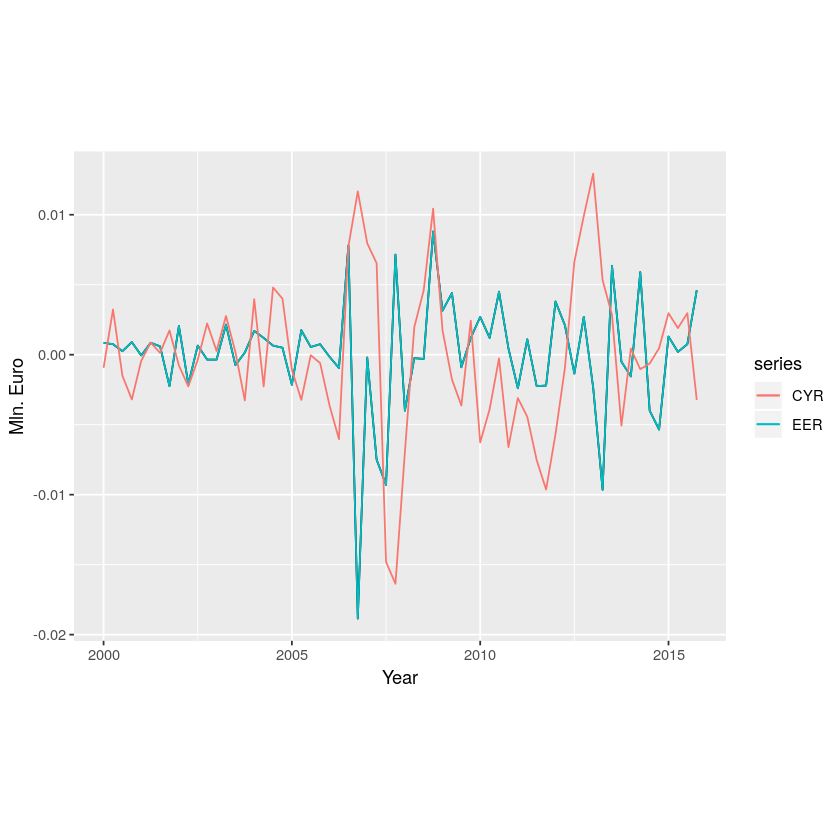

In [19]:
autoplot(ts(train[[names_dtw[iii]]], frequency = 4, start = 2000)) +
    autolayer(ts(train[[names_dtw[iii]]], frequency = 4, start = 2000), series=names_dtw[iii]) +
    autolayer(ts(train[[iii]], frequency = 4, start = 2000), series=colnames(train)[iii]) +
    xlab("Year") + ylab("Mln. Euro") +
    theme(aspect.ratio = 0.75)

#### 1 LAG

In [20]:
y  <-  hts(df_eu, characters = c(2,1))
gts_train  <- window(y, start=1, end=68)
gts_test  <- window(y, start=69, end=75)

In [21]:
names_dtw_1  <-  c(rep(NA, 29), names_dtw)
allts <- aggts(gts_train)
allf <- matrix(, nrow=7, ncol=ncol(allts))

In [26]:
start_time <- Sys.time()
for(i in 1:29){
    model  <- Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, method = "ML")
    allf[,i] <- forecast(model, h=7)$mean
}
ms <-  foreach(i=30:ncol(allts)) %dopar% {
    reg1  <-  lag(diff(diff(allts[,names_dtw_1[i]][1:length(allts[,names_dtw_1[i]])]),4))
    reg1  <- c(rep(NA, 5), reg1)
    tryCatch(        
        Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = reg1, method = "ML"), 
            error = function(e) Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = reg1, method = "CSS"))
    
#     forecast(ms[[i]], h=7)$mean
}
end_time <- Sys.time()
end_time - start_time

Time difference of 12.86301 secs

In [37]:
diff_y  <-  apply(y[[1]] , 2 , function(x) diff(diff(x), 4) ) 
                        


[1]  70 280

In [40]:
gts_xreg  <- window(diff_y, start=68-5, end=74-5)

In [41]:
gts_xreg

ATA,ATB,ATF,ATG,ATJ,ATK,ATL,ATM,ATO,ATR,⋯,UKA,UKB,UKF,UKG,UKJ,UKK,UKL,UKM,UKO,UKR
0.00630,0.40780,0.13835,0.05655,-0.01460,-0.18840,0.0479,0.23695,-0.01220,-0.01085,⋯,-0.00795,1.92935,0.17070,0.70425,-0.11980,-5.38075,-1.37315,-0.97275,-1.09620,-0.36660
0.07250,0.15465,-0.04570,0.13165,-0.06845,0.18050,-0.0162,-0.16945,-0.00710,0.04070,⋯,0.35510,6.79825,3.38565,6.99580,2.14565,2.75060,5.08305,5.37945,5.63630,3.04505
-0.00980,0.02490,-0.00425,0.11460,0.01215,-0.00275,-0.0098,0.00305,0.02810,-0.00035,⋯,0.04050,-1.72035,0.88740,1.47110,1.46460,0.92330,2.20625,1.00225,2.42605,0.58310
0.07880,-0.15275,-0.02590,-0.14125,0.01300,0.09940,0.0393,0.20725,-0.00400,-0.01480,⋯,0.12780,3.49245,1.76575,3.12405,0.58045,-2.15725,3.51980,3.34375,3.75000,0.91755
0.05690,-0.43785,-0.01630,0.10210,0.03595,0.16270,0.0493,-0.12535,-0.01410,0.01890,⋯,0.02175,2.56165,0.43940,2.35265,1.46140,2.13995,2.35705,2.78580,3.95085,-0.05895
-0.08990,0.54270,0.00520,0.11595,-0.02295,0.00070,0.0526,0.24835,0.16715,0.00935,⋯,-0.17980,-0.98770,-1.33915,-1.11795,-0.04125,0.74560,-0.54475,-0.41695,-0.44505,-1.46680
-0.06265,0.13300,0.03770,-0.01715,-0.01285,-0.24920,0.0234,-0.18515,-0.05915,-0.00640,⋯,-0.03665,1.44015,0.25225,2.01935,-0.36590,0.43090,-0.25385,0.47640,0.34935,-0.35890


In [43]:
for(i in 30:ncol(allts)){
    allf[,i] <- forecast(ms[[i-29]], h=7, xreg=gts_xreg[,names_dtw_1[i]])$mean
    }

Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[, names_dtw_1[i]]):
“xreg contains different column names fro

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warnin

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warnin

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warnin

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warnin

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warnin

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warnin

In [44]:
allf <- ts(allf)
colnames(allf)  <-  colnames(allts)  
g <- get_nodes(gts_train)
y.f <- combinef(allf, nodes = g)
forecasts_7  <-  y.f[[1]]
colnames(forecasts_7)  <-  colnames(y[[1]])
data_f5  <-  rbind(gts_train[[1]], forecasts_7)
y_f5  <-  hts(data_f5, characters = c(2,1))

In [45]:
gts_forecasts_7  <- window(y_f5, start=69, end=75)

In [46]:
accuracy.gts(gts_forecasts_7, gts_test)

,Total,AT,BE,BG,CY,CZ,DE,DK,EE,EL,⋯,UKA,UKB,UKF,UKG,UKJ,UKK,UKL,UKM,UKO,UKR
ME,55.501448,0.1125630,-0.4299992,-0.7849158,-1.158535,1.420364,20.86544,-0.6571684,-1.007498,0.1725471,⋯,0.2434845,5.889967,3.132027,5.108254,0.7161722,-2.715688,6.644817,5.208528,0.7650666,1.790807
RMSE,56.465483,0.5974718,0.5820364,0.8954993,1.249613,1.708852,22.66124,1.1097421,1.094386,0.5658500,⋯,0.5179470,6.155713,3.183228,5.247423,0.8643505,3.304244,6.782218,5.433138,2.9050155,2.007590
MAE,55.501448,0.4903995,0.5249689,0.7849158,1.158535,1.533306,20.86544,0.9435127,1.007498,0.4302058,⋯,0.4225127,5.889967,3.132027,5.108254,0.7774204,2.766762,6.644817,5.208528,2.4459026,1.790807
MAPE,1.593813,0.5795264,0.5300535,6.9243470,26.595872,3.381756,2.76423,1.4826516,18.938437,1.0648301,⋯,12.2783123,7.931727,9.772181,5.459555,2.2575515,7.601880,9.385564,7.839966,2.6444235,8.001337
MPE,1.593813,0.1247395,-0.4310618,-6.9243470,-26.595872,3.094275,2.76423,-1.0292785,-18.938437,0.4078980,⋯,6.7273030,7.931727,9.772181,5.459555,2.0689037,-7.468843,9.385564,7.839966,0.8226324,8.001337


#### 4 LAG

In [62]:
names_dtw_1  <-  c(rep(NA, 29), names_dtw)
allts <- aggts(gts_train)
allf <- matrix(, nrow=7, ncol=ncol(allts))

In [63]:
start_time <- Sys.time()
for(i in 1:29){
    model  <- Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, method = "ML")
    allf[,i] <- forecast(model, h=7)$mean
}
ms <-  foreach(i=30:ncol(allts)) %dopar% {
    reg1  <-  lag(allts[,names_dtw_1[i]][1:length(allts[,names_dtw_1[i]])],4)
    tryCatch(        
        Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = reg1, method = "ML"), 
            error = function(e) Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = reg1, method = "CSS"))
#     forecast(ms[[i]], h=7)$mean
}
end_time <- Sys.time()
end_time - start_time

Time difference of 11.20913 secs

In [64]:
gts_xreg  <- window(y, start=(69-4), end=(75-4))

In [65]:
for(i in 30:ncol(allts)){
    allf[,i] <- forecast(ms[[i-29]], h=7, xreg=gts_xreg[[1]][,names_dtw_1[i]])$mean
    }

Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains d

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in th

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in th

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in th

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in th

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in th

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = gts_xreg[[1]][, names_dtw_1[i]]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in th

In [66]:
allf <- ts(allf)
colnames(allf)  <-  colnames(allts)  
g <- get_nodes(gts_train)
y.f <- combinef(allf, nodes = g)
forecasts_7  <-  y.f[[1]]
colnames(forecasts_7)  <-  colnames(y[[1]])
data_f5  <-  rbind(gts_train[[1]], forecasts_7)
y_f5  <-  hts(data_f5, characters = c(2,1))

In [67]:
gts_forecasts_7  <- window(y_f5, start=69, end=75)

In [68]:
accuracy.gts(gts_forecasts_7, gts_test)

,Total,AT,BE,BG,CY,CZ,DE,DK,EE,EL,⋯,UKA,UKB,UKF,UKG,UKJ,UKK,UKL,UKM,UKO,UKR
ME,55.512479,0.1022771,-0.4395500,-0.7946160,-1.170366,1.387287,20.90435,-0.6315799,-1.016124,0.1737342,⋯,0.2872894,4.665377,2.756745,5.325807,1.151533,-3.030940,5.346452,5.749738,2.890954,1.644250
RMSE,56.475765,0.5894329,0.5886386,0.9026293,1.259719,1.674255,22.67413,1.0909112,1.101055,0.5733086,⋯,0.5408341,5.050177,2.784401,5.588334,1.357164,3.579698,5.470968,5.891257,3.762609,1.897879
MAE,55.512479,0.4858416,0.5331019,0.7946160,1.170366,1.504216,20.90435,0.9231261,1.016124,0.4400365,⋯,0.4648980,4.665377,2.756745,5.325807,1.151533,3.030940,5.346452,5.749738,3.503482,1.644250
MAPE,1.594132,0.5745180,0.5382426,7.0060511,26.871940,3.318857,2.76960,1.4507210,19.106906,1.0895971,⋯,13.5996966,6.259877,8.605243,5.683429,3.332247,8.313038,7.547727,8.674643,3.793116,7.345663
MPE,1.594132,0.1125122,-0.4407288,-7.0060511,-26.871940,3.021227,2.76960,-0.9891117,-19.106906,0.4109163,⋯,8.1179560,6.259877,8.605243,5.683429,3.332247,-8.313038,7.547727,8.674643,3.128696,7.345663


#### 1, 4 LAGS

In [69]:
allf <- matrix(, nrow=7, ncol=ncol(allts))

In [70]:
start_time <- Sys.time()
for(i in 1:29){
    model  <- Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, method = "ML")
    allf[,i] <- forecast(model, h=7)$mean
}
ms <-  foreach(i=30:ncol(allts)) %dopar% {
    reg1  <-  lag(allts[,names_dtw_1[i]][1:length(allts[,names_dtw_1[i]])])
    reg4  <-  lag(allts[,names_dtw_1[i]][1:length(allts[,names_dtw_1[i]])],4)
     
    
    tryCatch(        
        Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = cbind(reg1,reg4), method = "ML"), 
            error = function(e) Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = cbind(reg1,reg4), method = "CSS"))
#
    
    #     forecast(ms[[i]], h=7)$mean
}
end_time <- Sys.time()
end_time - start_time

Time difference of 13.2985 secs

In [71]:
gts_xreg1  <- window(y, start=(69-1), end=(75-1))
gts_xreg4  <- window(y, start=(69-4), end=(75-4))

In [72]:
for(i in 30:ncol(allts)){
    reg1f  <-  ts(gts_xreg1[[1]][,names_dtw_1[i]], start=2017)
    reg4f  <-  ts(gts_xreg4[[1]][,names_dtw_1[i]], start=2017)
    allf[,i] <- forecast(ms[[i-29]], h=7, xreg=cbind(reg1f,reg4f))$mean
    }

Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg4f)):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(

In [73]:
allf <- ts(allf)
colnames(allf)  <-  colnames(allts)  
g <- get_nodes(gts_train)
y.f <- combinef(allf, nodes = g)
forecasts_7  <-  y.f[[1]]
colnames(forecasts_7)  <-  colnames(y[[1]])
data_f5  <-  rbind(gts_train[[1]], forecasts_7)
y_f5  <-  hts(data_f5, characters = c(2,1))

In [74]:
gts_forecasts_7  <- window(y_f5, start=69, end=75)

In [75]:
accuracy.gts(gts_forecasts_7, gts_test)

,Total,AT,BE,BG,CY,CZ,DE,DK,EE,EL,⋯,UKA,UKB,UKF,UKG,UKJ,UKK,UKL,UKM,UKO,UKR
ME,55.478561,0.1247961,-0.4037477,-0.7669695,-1.140032,1.391935,20.79931,-0.6029052,-0.9864235,0.2077608,⋯,0.6462715,4.754368,3.800245,4.795635,1.280039,-0.8057532,5.785136,3.699253,0.3515941,2.096999
RMSE,56.439562,0.5989093,0.5531841,0.8749793,1.227420,1.680534,22.58271,1.0631539,1.0693626,0.5864389,⋯,0.8003203,5.090672,3.851871,5.036349,1.508289,1.5536247,5.911129,3.797697,3.4658513,2.267025
MAE,55.478561,0.4896359,0.4952527,0.7669695,1.140032,1.510999,20.79931,0.8930889,0.9864235,0.4313011,⋯,0.6462715,4.754368,3.800245,4.795635,1.280039,1.3145303,5.785136,3.699253,2.5627295,2.096999
MAPE,1.593163,0.5786920,0.5000040,6.7666526,26.177778,3.334308,2.75552,1.4035821,18.5515984,1.0655580,⋯,18.8586163,6.384618,11.863538,5.116980,3.701034,3.6038528,8.170257,5.592397,2.7676820,9.384918
MPE,1.593163,0.1391835,-0.4046238,-6.7666526,-26.177778,3.031246,2.75552,-0.9441322,-18.5515984,0.4959133,⋯,18.8586163,6.384618,11.863538,5.116980,3.701034,-2.2748278,8.170257,5.592397,0.3620899,9.384918


#### 1:4 LAGS

In [76]:
allf <- matrix(, nrow=7, ncol=ncol(allts))

In [77]:
start_time <- Sys.time()
for(i in 1:29){
    model  <- Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, method = "ML")
    allf[,i] <- forecast(model, h=7)$mean
}
ms <-  foreach(i=30:ncol(allts)) %dopar% {
    reg1  <-  lag(allts[,names_dtw_1[i]][1:length(allts[,names_dtw_1[i]])])
    reg2  <-  lag(allts[,names_dtw_1[i]][1:length(allts[,names_dtw_1[i]])],2)
    reg3  <-  lag(allts[,names_dtw_1[i]][1:length(allts[,names_dtw_1[i]])],3)
    reg4  <-  lag(allts[,names_dtw_1[i]][1:length(allts[,names_dtw_1[i]])],4)
    
    tryCatch(        
        Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = cbind(reg1,reg2,reg3,reg4), method = "ML"), 
            error = function(e) Arima(msts(allts[,i], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = cbind(reg1,reg2,reg3,reg4), method = "CSS"))
#
    
    #     forecast(ms[[i]], h=7)$mean
}
end_time <- Sys.time()
end_time - start_time

Time difference of 18.77361 secs

In [78]:
gts_xreg1  <- window(y, start=(69-1), end=(75-1))
gts_xreg2  <- window(y, start=(69-2), end=(75-2))
gts_xreg3  <- window(y, start=(69-3), end=(75-3))
gts_xreg4  <- window(y, start=(69-4), end=(75-4))

In [79]:
for(i in 30:ncol(allts)){
    reg1f  <-  ts(gts_xreg1[[1]][,names_dtw_1[i]], start=2017)
    reg2f  <-  ts(gts_xreg2[[1]][,names_dtw_1[i]], start=2017)
    reg3f  <-  ts(gts_xreg3[[1]][,names_dtw_1[i]], start=2017)
    reg4f  <-  ts(gts_xreg4[[1]][,names_dtw_1[i]], start=2017)
    allf[,i] <- forecast(ms[[i-29]], h=7, xreg=cbind(reg1f,reg2f,reg3f,reg4f))$mean
    }

Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[i - 29]], h = 7, xreg = cbind(reg1f, reg2f, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(

In [80]:
allf <- ts(allf)
colnames(allf)  <-  colnames(allts)  
g <- get_nodes(gts_train)
y.f <- combinef(allf, nodes = g)
forecasts_7  <-  y.f[[1]]
colnames(forecasts_7)  <-  colnames(y[[1]])
data_f5  <-  rbind(gts_train[[1]], forecasts_7)
y_f5  <-  hts(data_f5, characters = c(2,1))

In [81]:
gts_forecasts_7  <- window(y_f5, start=69, end=75)

In [82]:
accuracy.gts(gts_forecasts_7, gts_test)

,Total,AT,BE,BG,CY,CZ,DE,DK,EE,EL,⋯,UKA,UKB,UKF,UKG,UKJ,UKK,UKL,UKM,UKO,UKR
ME,55.446862,0.1742296,-0.3533016,-0.7388572,-1.109503,1.380407,20.740904,-0.5668500,-0.9580455,0.2454152,⋯,1.184153,5.671124,3.711367,5.879254,2.086687,-1.414525,3.641393,2.520480,-0.1154639,2.580816
RMSE,56.406031,0.6386982,0.5021615,0.8459059,1.194646,1.666076,22.543741,1.0338542,1.0390434,0.6016166,⋯,1.319288,5.985438,3.772283,6.264199,2.443270,2.207170,4.040534,2.565591,3.2893238,2.687184
MAE,55.446862,0.5152705,0.4443610,0.7388572,1.109503,1.499103,20.740904,0.8698595,0.9580455,0.4317902,⋯,1.184153,5.671124,3.711367,5.879254,2.086687,1.864939,3.641393,2.520480,2.2619492,2.580816
MAPE,1.592258,0.6081397,0.4487156,6.5254981,25.481167,3.308670,2.747614,1.3672969,18.0225434,1.0654691,⋯,34.782997,7.627186,11.590275,6.270829,6.035194,5.112519,5.132324,3.818204,2.4447491,11.563223
MPE,1.592258,0.1974189,-0.3537996,-6.5254981,-25.481167,3.006544,2.747614,-0.8875573,-18.0225434,0.5915087,⋯,34.782997,7.627186,11.590275,6.270829,6.035194,-3.937004,5.132324,3.818204,-0.1432201,11.563223


#### DTWARP CV

In [85]:
df_eu  <- as.data.table(df_eu)

In [86]:
per  <-  4

cm  <- foreach(i=0:per) %dopar% {
    st_year  <-  1 + 4*i
    train_start  <- st_year
    train_end  <- st_year + 1*51

    train  <- df_eu_diff_4[1:(train_end-5), ]  

    corr_mat <- diss(train, "DTWARP")
    }
        

In [87]:
cm[[1]][1]

[1] 21.7135

In [88]:
num_dtw  <-  nam_dtw <- list()

for (k in 0:per){
    st_year  <-  1 + 4*k
    train_start  <- st_year
    train_end  <- st_year + 1*51
    train  <- df_eu_diff_4[1:(train_end-5), ]  
    diss_mat_dtw  <- matrix(0, nrow = dim(train)[2], ncol = dim(train)[2])
    i <- j  <- a  <- 1
    while (i < dim(train)[2]){
      for (j in (i+1):dim(train)[2]){ 
        # cat("(", j, i, ")")
        diss_mat_dtw[j,i] <-  cm[[k+1]][a]
        a <- a+1
        }
      i <-i+1
      }
    diss_mat_dtw  <- diss_mat_dtw + t(diss_mat_dtw)
    diag(diss_mat_dtw) <- NA
    
    closests_dtw <- c()
    for (i in 1:dim(df_eu)[2]){
        closests_dtw  <-  c(closests_dtw, which.min(diss_mat_dtw[i,]) )
    }
    names_dtw <- c()
    for (i in closests_dtw){
        names_dtw  <-  c(names_dtw, colnames(train)[i])
    }
    
    num_dtw[[k+1]] <- closests_dtw
    nam_dtw[[k+1]] <- names_dtw
    
    }

In [89]:
num_dtw  <- data.frame(matrix(unlist(num_dtw), nrow=(per+1), byrow=T))
nam_dtw  <- data.frame(matrix(unlist(nam_dtw), nrow=(per+1), byrow=T))

In [90]:
table(num_dtw[,7])


218 258 
  2   3 

In [91]:
dddd  <-  t(data.frame(sapply(num_dtw, function(x) sort(table(x),  decreasing = TRUE)[1]) ))
dddd  <-  rbind(dddd, as.numeric(gsub("^.*\\.","",colnames(dddd))))                              
dddd  <-  rbind(dddd, sapply(num_dtw[2,], function(x) colnames(train)[x]))   
rownames(dddd)  <- NULL                             

In [92]:
dddd

X1.11,X2.263,X3.144,X4.194,X5.190,X6.217,X7.258,X8.198,X9.259,X10.200,⋯,X271.111,X272.277,X273.275,X274.277,X275.92,X276.112,X277.278,X278.277,X279.274,X280.269
2,4,3,2,2,4,3,3,4,3,⋯,4,5,4,5,4,3,3,3,5,3
11,263,144,194,190,217,258,198,259,200,⋯,111,277,275,277,92,112,278,277,274,269
ATA,SEF,CZK,ATG,NLR,HUA,FIM,ATM,FIO,FIR,⋯,ITA,UKL,UKJ,UKL,FRB,ITB,UKM,UKF,UKG,SEO


In [93]:
nam_dtw

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X271,X272,X273,X274,X275,X276,X277,X278,X279,X280
ATA,DKG,SKF,ATG,ATJ,PTL,FIM,ATM,FIO,ATR,⋯,ITA,UKL,DEM,UKL,FRB,UKF,UKM,DEM,UKG,SEO
ATA,SEF,CZK,ATG,NLR,HUA,FIM,ATM,FIO,FIR,⋯,ITA,UKL,UKJ,UKL,FRB,ITB,UKM,UKF,UKG,SEO
BGM,SEF,LTG,HUB,HRM,PTL,FIM,ATG,FIO,ATR,⋯,SKB,UKL,UKJ,UKL,FRB,UKF,UKM,UKL,UKG,SEM
BGA,SEF,LTG,ESJ,NLR,PTL,PTM,ATG,FIO,FIR,⋯,ITA,UKL,UKJ,UKL,FRB,ITB,UKG,UKL,UKG,SEO
BGA,SEF,LTG,BEO,LVG,PTL,PTM,ATM,ITR,ATR,⋯,ITA,UKL,UKJ,UKL,UKR,ITB,UKG,UKL,UKG,ESK


#### 1 LAG (auto)

In [94]:
df_eu  <- as.data.table(df_eu)
y  <-  hts(df_eu, characters = c(2,1))
s  <-  smatrix(y)

In [95]:
per  <-  4
# ac <- c()
m_top  <- l_top <- list()
df_ac_sa  <-  data.frame(matrix(ncol = 0, nrow = 0))

In [96]:
i  <-  1
j <- 40
# lag(allts[,nam_dtw[(i+1),(j-29)]][1:length(allts[,nam_dtw[(i+1),(j-29)]])])
gts_xreg[[1]][,nam_dtw[(i+1),(j-29)] ]

Time Series:
Start = 65 
End = 71 
Frequency = 1 
[1] 0.95390 1.13995 0.97825 0.89065 1.03250 1.20875 1.12585

In [97]:
for (i in 1:per){ # Not enough data to fit the model
    st_year  <-  1 + 4*i
    train_start  <- st_year
    train_end  <- st_year + 1*51
    test_start  <- st_year + 1*(51+1) 
    test_end  <-  st_year + 1*(51+8)
    
    print(c(train_start, train_end, test_start, test_end))
    
    gts_train <- window(y, end=train_end)
    
    if (i == 4){
        gts_test <- window(y, start=test_start)
        t_e  <-  dim(y[[1]])[1]
        hh  <-  7
    }
    else{
        gts_test <- window(y, start=test_start, end=test_end)
        t_e  <-  test_end
        hh  <-  8 
    }
    
    allts <- aggts(gts_train)
    allf <- matrix(, nrow=hh, ncol=ncol(allts))

    
    for(j in 1:29){
        model  <- tryCatch(        
            Arima(msts(allts[,j], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, method = "ML"), 
                error = function(e) Arima(msts(allts[,j], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, method = "CSS"))
        allf[,j] <- forecast(model, h=hh)$mean
    }

        
    ms <-  foreach(j=30:ncol(allts)) %dopar% {
        reg1  <-  lag(allts[,nam_dtw[(i+1),(j-29)]][1:length(allts[,nam_dtw[(i+1),(j-29)]])])
        tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = reg1, method = "ML"), 
            error = function(e) Arima(msts(allts[,j], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = reg1, method = "CSS"))
    }
    
    

    gts_xreg  <- window(y, start=(test_start-1), end=(t_e-1))        
    
    for(j in 30:ncol(allts)){
        allf[,j] <- forecast(ms[[j-29]], h=hh, xreg=gts_xreg[[1]][,nam_dtw[(i+1),(j-29)] ])$mean
    }        
            
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5, characters = c(2,1))
    
    
    if (i == 4){
        gts_forecasts_7 <- window(y_f5, start=test_start)}
    else{
        gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
    }
        
#     ac  <-  c(ac, accuracy(gdp_arima, test)[2, 2])
    df_ac_sa  <-  bind_rows(df_ac_sa, accuracy.gts(gts_forecasts_7, gts_test)[, 1]) 
    }

[1]  5 56 57 64


Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different c

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

[1]  9 60 61 68


Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different c

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

[1] 13 64 65 72


Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different c

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

[1] 17 68 69 76


Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different c

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, nam_dtw[(i + :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same o

In [100]:
df_ac_sa

ME,RMSE,MAE,MAPE,MPE
58.47031,74.00296,58.47031,1.768984,1.768984
60.62141,66.40824,60.62141,1.816584,1.816584
-60.77034,67.66307,61.36919,1.825033,-1.808073
58.00018,58.92509,58.00018,1.665786,1.665786


In [101]:
colMeans(df_ac_sa)

ME       RMSE        MAE       MAPE        MPE 
29.0803889 66.7498416 59.6152727  1.7690969  0.8608205

#### 1 LAG (same neighbor)

In [102]:
df_eu  <- as.data.table(df_eu)
y  <-  hts(df_eu, characters = c(2,1))
s  <-  smatrix(y)

In [103]:
per  <-  4
# ac <- c()
m_top  <- l_top <- list()
df_ac_sa  <-  data.frame(matrix(ncol = 0, nrow = 0))

In [104]:
for (i in 1:per){ # Not enough data to fit the model
    st_year  <-  1 + 4*i
    train_start  <- st_year
    train_end  <- st_year + 1*51
    test_start  <- st_year + 1*(51+1) 
    test_end  <-  st_year + 1*(51+8)
    
    print(c(train_start, train_end, test_start, test_end))
    
    gts_train <- window(y, end=train_end)
    
    if (i == 4){
        gts_test <- window(y, start=test_start)
        t_e  <-  dim(y[[1]])[1]
        hh  <-  7
    }
    else{
        gts_test <- window(y, start=test_start, end=test_end)
        t_e  <-  test_end
        hh  <-  8 
    }
    
    allts <- aggts(gts_train)
    allf <- matrix(, nrow=hh, ncol=ncol(allts))

    
    for(j in 1:29){
        model  <- tryCatch(        
            Arima(msts(allts[,j], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, method = "ML"), 
                error = function(e) Arima(msts(allts[,j], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, method = "CSS"))
        allf[,j] <- forecast(model, h=hh)$mean
    }

        
    ms <-  foreach(j=30:ncol(allts)) %dopar% {
        reg1  <-  lag(allts[,dddd[3,(j-29)]][1:length(allts[,dddd[3,(j-29)]])])
        tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = reg1, method = "ML"), 
            error = function(e) Arima(msts(allts[,j], seasonal.periods = 4), order=c(3,0,0), seasonal=c(2,0,0), include.drift = TRUE, include.mean = TRUE, xreg = reg1, method = "CSS"))
    }
    
    

    gts_xreg  <- window(y, start=(test_start-1), end=(t_e-1))        
    
    for(j in 30:ncol(allts)){
        allf[,j] <- forecast(ms[[j-29]], h=hh, xreg=gts_xreg[[1]][,dddd[3,(j-29)] ])$mean
    }        
            
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5, characters = c(2,1))
    
    
    if (i == 4){
        gts_forecasts_7 <- window(y_f5, start=test_start)}
    else{
        gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
    }
        
#     ac  <-  c(ac, accuracy(gdp_arima, test)[2, 2])
    df_ac_sa  <-  bind_rows(df_ac_sa, accuracy.gts(gts_forecasts_7, gts_test)[, 1]) 
    }

[1]  5 56 57 64


Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

[1]  9 60 61 68


Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

[1] 13 64 65 72


Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

[1] 17 68 69 76


Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(ms[[j - 29]], h = hh, xreg = gts_xreg[[1]][, dddd[3, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning messag

In [105]:
df_ac_sa

ME,RMSE,MAE,MAPE,MPE
55.08366,71.32339,55.08366,1.664217,1.664217
57.54929,63.62525,57.54929,1.724353,1.724353
-63.66300,70.26122,63.66300,1.893369,-1.893369
55.45627,56.41711,55.45627,1.592523,1.592523


In [106]:
colMeans(df_ac_sa)

ME       RMSE        MAE       MAPE        MPE 
26.1065554 65.4067407 57.9380545  1.7186155  0.7719308